# Construct of general ANM matrix using PP
using PP for ANM is quite a lot more complicated and tedious than all-electron systems.
This note book attempt to create a readable/reusable script to construct PP ANM matrix

In [24]:
import qctoolkit as qtk
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# reuse code from PRM paper
cyl_map = [
        ['si', 5.431, [14, 14]],
        ['ge', 5.658, [32, 32]],
        ['sige', 5.432, [14, 32]],
        ['sn', 6.4892, [50, 50]],
        ['snsi', 5.961, [14, 50]],
        ['gesn', 6.0758, [32, 50]],
        ['gaas', 5.6535, [31, 33]],
        ['alp', 5.4635, [13, 15]],
        ['alas', 5.660, [13, 33]],
        ['alsb', 6.1355, [13, 51]],
        ['gap', 5.451, [31, 15]],
        ['gasb', 6.09, [31, 51]],
        ['inp', 5.86, [49, 15]],
        ['inas', 6.05, [49, 33]],
        ['insb', 6.47, [49, 51]],

]
print len(cyl_map)

15


In [3]:
# only CPMD PP interface is ready at the moment
# only Gamma-point calculations are required
qmsetting = {
    'program': 'cpmd',
    'kmesh': [1,1,1],
    'link_dep': False,
}

In [4]:
mol_base = qtk.Molecule('xyz/ge.xyz')
# mol_base.extend([2,2,2])
# mol_base.sort(order='xyz')

# ANM space and finite difference matrix
ANM space is spanned by the PP parameters. For FCC primitive cell of two atoms, there are 30 parameters (15 per atoms).

The goal is the construct matrix elements 
$$
\begin{array}{rcl}
\mathbf{H}_{ij}&=&\frac{\partial^2 E}{\partial\sigma_i\partial\sigma_j}\\
&=&\frac{\partial}{\partial\sigma_i}\Big(\frac{\partial E}{\partial\sigma_j}\Big)\\
&\approx&
\frac{\partial}{\partial\sigma_i}\Big(\frac{E(\sigma_i, \sigma_j+\Delta\sigma_j) - E(\sigma_i, \sigma_j)}{\Delta\sigma_j}\Big)\\
&\approx&
\frac{1}{\Delta\sigma_i}\Bigg(\frac{E(\sigma_i+\Delta\sigma_i, \sigma_j+\Delta\sigma_j) - E(\sigma_i+\Delta\sigma_i, \sigma_j)}{\Delta\sigma_j}
- \frac{E(\sigma_i, \sigma_j+\Delta\sigma_j) - E(\sigma_i, \sigma_j)}{\Delta\sigma_j}\Bigg).
\end{array}
$$

That is, there are four finite difference calculations required for each of the matrix elements:
$E(\sigma_i+\Delta\sigma_i, \sigma_j+\Delta\sigma_j)$, 
$E(\sigma_i+\Delta\sigma_i, \sigma_j)$, 
$E(\sigma_i, \sigma_j+\Delta\sigma_j)$, 
$E(\sigma_i, \sigma_j)$, 
where only the first term is unique for each element.

Note that the finite difference formula is different for diagonal terms $\mathbf{H}_{ii} = \frac{E(\sigma_i+\Delta\sigma_i) - 2E(\sigma_i) + E(\sigma_i-\Delta\sigma_i)}{\Delta\sigma_i^2}$.

The required finite difference calculations are
* $E(\sigma_i+\Delta\sigma_i, \sigma_j+\Delta\sigma_j)$: $N(N-1)/2$ calculations for $i\neq j$
* $E(\sigma_i+\Delta\sigma_i)$: $N$ calculations
* $E(\sigma_i-\Delta\sigma_i)$: $N$ calculations
* $E(\sigma_i, \sigma_j)$: 1 calculation

which added up to $\frac{N^2}{2}+\frac{3}{2}N+1$ calculations, where $N$ is the number of parameters in the system.

# Function interface
The following functions are required for reusable/extensive code

## _crystal to parameter space map_: cyl2par
input: crystal object

output: parameter space coordinate

## _parameter spsce to crystal map_: par2cyl
input: parameter space coordinate

output: crystal object

## _finite difference crystal construction_: FDcyl
input: finite difference indices, step size

output: QMInp calculation object

__NOTE__: for the construction of FD matrix, the index information will be written on the file name for lazy processing

## _finite difference matrix construction_: H_FD
input: finite difference calculation folder path __with fomated index file name__

output: finite difference matrix as 2D numpy array

### TODO:
implement CPMD interface to take PP object as input and write PP file on the fly __DONE__

In [5]:
def cyl2par(mol, size=[1, 3]):
    par = []
    for a in mol.type_list:
        crd = qtk.PP(a, size=size)
        vec = crd.vectorize()
        par.append([vec[0][1:], a, vec[0][0]])
    return par

def par2cyl(par, mol_base=mol_base, size=[1, 3]):
    mol = mol_base.copy()
    mol.sort(order='xyz')
    for i, crd in enumerate(par):
        pp = qtk.PP(crd[1], size=size)
        vec = [crd[2]]
        vec.extend(crd[0])
        pp.unvectorize(vec, size[0], range(size[1], 0, -1))
        pp.name = crd[1] + '%02d' % i
        mol.setAtoms(i, string=pp)
    return mol

mol = par2cyl(cyl2par(mol_base))
inp = qtk.QMInp(mol, **qmsetting)
inp.write()

&INFO
 ge
&END

&CPMD
 MIRROR
 BENCHMARK
  1 0 0 0 0 0 0 0 0 0
 OPTIMIZE WAVEFUNCTION
 CONVERGENCE ORBITAL
  1.00E-05
 MAXITER
  1000
 CENTER MOLECULE OFF
 MEMORY BIG
&END

&DFT
 FUNCTIONAL PBE
&END

&SYSTEM
 CELL VECTORS
     0.000000    2.715500    2.715500
     2.715500    0.000000    2.715500
     2.715500    2.715500    0.000000
 ANGSTROM
 CUTOFF
  100.0
 KPOINTS MONKHORST-PACK
  1 1 1
&END

&ATOMS
*Ge01.psp
 LMAX=F
   1
     3.8411   3.8411   3.8411
*Ge00.psp
 LMAX=F
   1
     0.0000   0.0000   0.0000
&END


# parameter step size analysis

0.035122203 11.00886207
[0.06762277 5.36334649 0.08824736 3.5593494  1.74631595 0.52367548
 2.92243393 1.35212429 1.07321538 0.08707343 0.96369822 0.24900187
 0.29462299 0.4504635  0.11338763]
[ 0.52722222 -0.04649569  0.50824273  5.08123887 -0.42839218 -0.65027067
 -0.50461339  1.67899165 -1.33265831  0.58951056  1.1996453   0.32454234
 -0.38400367  0.6156998   0.13199626]


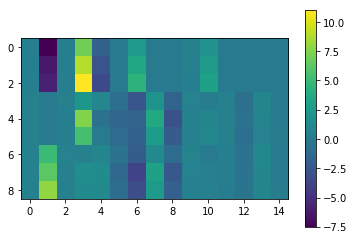

In [26]:
Zs = [13, 14, 15, 31, 32, 33, 49, 50, 51]
pp_par = np.vstack([qtk.PP(qtk.Z2n(Z), size=[1, 3]).vectorize()[0][1:] for Z in Zs])
ppp = abs(pp_par[np.nonzero(pp_par)])
pmin, pmax = min(ppp), max(ppp)
print pmin, pmax
print pp_par.std(axis=0)
print pp_par.mean(axis=0)
plt.imshow(pp_par)
plt.colorbar()

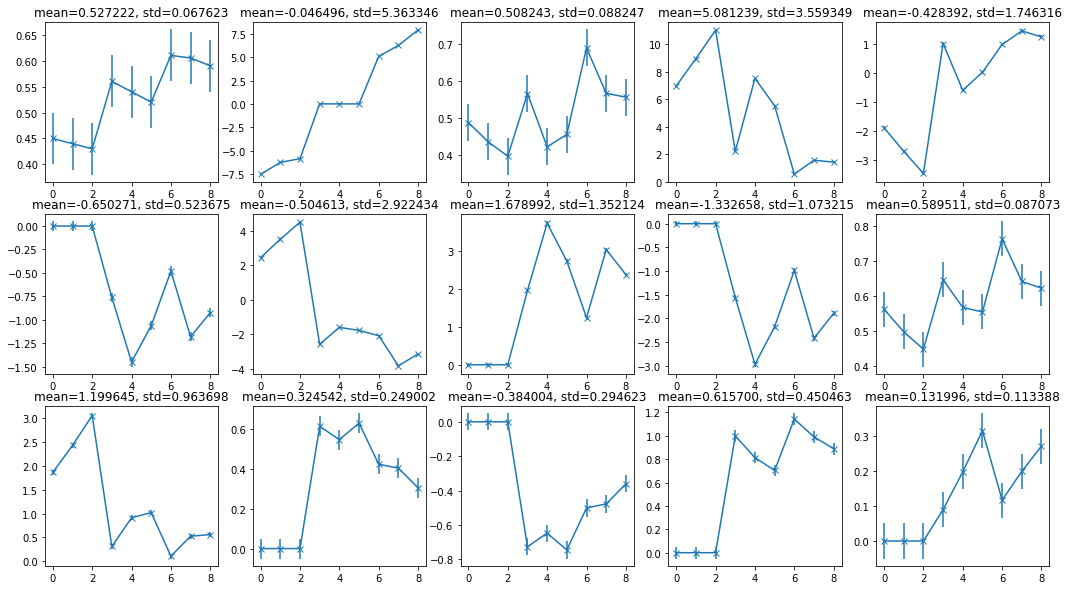

In [38]:
fix, axs = plt.subplots(3, 5, figsize=(18, 10))
stds = pp_par.std(axis=0)
means = pp_par.mean(axis=0)
for i in range(15):
    row, col = divmod(i, 5)
    ax = axs[row][col]
    par = pp_par[:, i]
    ax.errorbar(range(len(par)), par, yerr=0.05, marker='x')
    ax.set_title('mean=%f, std=%f' % (means[i], stds[i]))

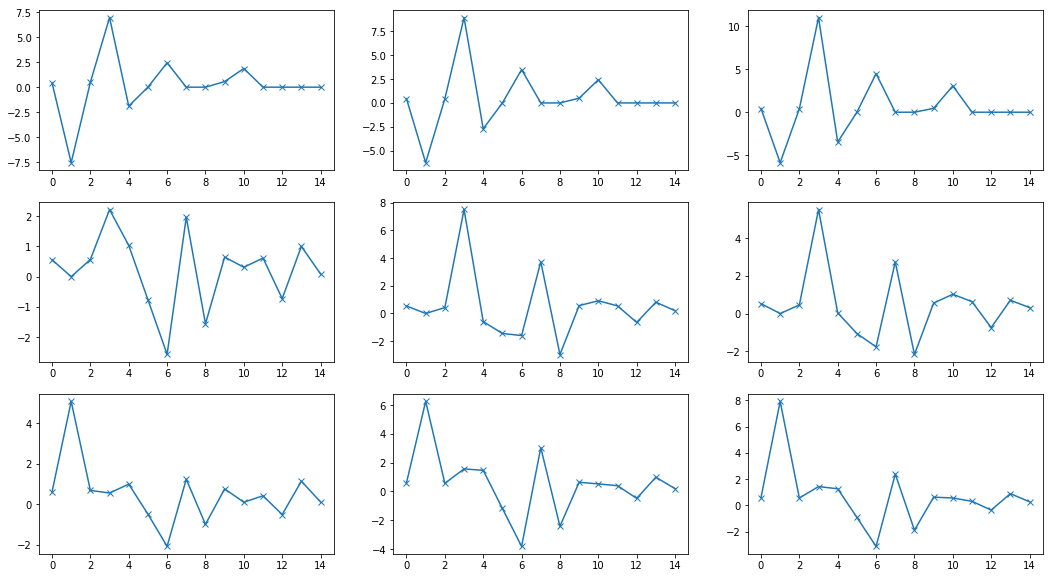

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(18, 10))
for i in range(9):
    row, col = divmod(i, 3)
    ax = axs[row][col]
    par = pp_par[i]
    ax.errorbar(range(len(par)), par, yerr=0.01, marker='x')

In [6]:
def FDcyl(mol, i, j, step, size=[1,3], dim=15):
    """
    input:  molecule object: where the FD perturbation will be introduced
            i, j: integer indices for the perturbation matrix row and column number
            step: absolute step size for finite difference perturbation
            size: PP configuration space
    output: molecule object with appropreate PP and file names attached
    """
    def get_pp(I, ip, font, mode='+'):
        if type(mol.string[I]) is type(qtk.PP()):
            pp = mol.string[I]
        else:
            pp = qtk.PP(mol.type_list[I], size=size)
            pp.name = mol.type_list[I]
        vec = pp.vectorize()[0]
        new_pp = pp.copy()
        if mode == '+':
            vec[1+ip] += step
        elif mode == '-':
            vec[1+ip] -= step
        new_pp.unvectorize(vec, size[0], range(size[1], 0, -1))
        new_pp.name += '_%s%02dp%02d' % (font, I, ip)
        return new_pp
    
    # first order
    if i == j:
        I, ip = divmod(i, dim)
        modes = [['p', '+'], ['m', '-']]
        mols = []
        for m in modes:
            mol_new = mol.copy()
            pp = get_pp(I, ip, 'I', mode=m[1])
            mol_new.setAtoms(I, string=pp)
            mol_new.name += '_i%02d%s-I%02dp%02d' % (i, m[0], I, ip)
            mols.append(mol_new)
        return mols
    # second order
    else:
        mol = mol.copy()
        inds = [i, j]
        ind_font = ['I', 'J']
        for t, s in enumerate([i, j]):
            I, ip = divmod(s, dim)
            inds.append(I)
            inds.append(ip)
            pp = get_pp(I, ip, ind_font[t])
            mol.setAtoms(I, string=pp)
        mol.name += "_i%02dj%02d-I%02dp%02d-J%02dp%02d" % tuple(inds)
    return [mol]

# mol_test = FDcyl(mol_base, 5, 28, 100)[0]
# inp = qtk.QMInp(mol_test, **qmsetting)
# inp.write('PPTest', overwrite=True)

## Construct FD crystal for calculations

In [ ]:
mols_fd = []
par = cyl2par(mol_base)

# get dimension of PP space
# single atom PP space * number of atoms
N = len(par[0][0]) * len(par)

for info_cyl in cyl_map:
    mols_c = []
    mols_info = [info_cyl[0] + '_H_scan', mols_c]
    mols_fd.append(mols_info)
    print "processing %s" % info_cyl[0]
    mol_c = mol_base.copy()
    for i in range(mol.N):
        mol_c.setAtoms(i, Z=info_cyl[2][i])
    mol_c.name = info_cyl[0]
    for info_a in cyl_map:
        mol_a = mol_c.copy()
        mol_a.name += '_a-' + info_a[0]
        mol_a.setCelldm([info_a[1], info_a[1], info_a[1], 0, 0, 0])
        mols_c.append(mol_a)
        # get off-diagonal terms
        for i in range(N):
            for j in range(i, N):
                mols = FDcyl(mol_a, i, j, step=0.01)
                mols_c.extend(mols)
    inps_c = [qtk.QMInp(m, **qmsetting) for m in mols_c]
    qtk.qmRunAll(inps_c, mols_info[0])
        
print len(mols_fd), len(mols_fd[0][1])

processing si
qmRunJob: runing qmjob:'si_a-si: cpmd' with name: si_a-si 
QMInp.run: running job with command: cpmd.x si_a-si.inp

qmRunJob: runing qmjob:'si_a-si_i00j02-I00p00-J00p02: cpmd' with name: si_a-si_i00j02-I00p00-J00p02 
qmRunJob: runing qmjob:'si_a-si_i00j01-I00p00-J00p01: cpmd' with name: si_a-si_i00j01-I00p00-J00p01 
qmRunJob: runing qmjob:'si_a-si_i00p-I00p00: cpmd' with name: si_a-si_i00p-I00p00 
qmRunJob: runing qmjob:'si_a-si_i00m-I00p00: cpmd' with name: si_a-si_i00m-I00p00 
qmRunJob: runing qmjob:'si_a-si_i00j04-I00p00-J00p04: cpmd' with name: si_a-si_i00j04-I00p00-J00p04 
qmRunJob: runing qmjob:'si_a-si_i00j07-I00p00-J00p07: cpmd' with name: si_a-si_i00j07-I00p00-J00p07 
qmRunJob: runing qmjob:'si_a-si_i00j03-I00p00-J00p03: cpmd' with name: si_a-si_i00j03-I00p00-J00p03 
qmRunJob: runing qmjob:'si_a-si_i00j08-I00p00-J00p08: cpmd' with name: si_a-si_i00j08-I00p00-J00p08 
qmRunJob: runing qmjob:'si_a-si_i00j05-I00p00-J00p05: cpmd' with name: si_a-si_i00j05-I00p00-J00p0

In [15]:
[len(mols[1]) for mols in mols_fd]

[6944,
 6944,
 6944,
 6944,
 6944,
 6944,
 6944,
 6944,
 6944,
 6944,
 6944,
 6944,
 6944,
 6944,
 6944]

In [21]:
mols_fd[1][1][496]

ge_a-sige

In [ ]:
# print "convert crystals to QMInp objects"
# inps_fd = [qtk.QMInp(mol_base, **qmsetting)]
# for m in mols_fd:
#     inps_fd.append(qtk.QMInp(m, **qmsetting))

In [ ]:
mols_ref[20].N

In [ ]:
len(inps_fd), len(mols_fd)

In [ ]:
ls

In [ ]:
qtk.pdump(inps_fd, 'a_scan_inp.pkl')

In [12]:
qtk.qmRunAll(inps_fd, "a_scan", threads=24)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/samio/miniconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/samio/miniconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/samio/miniconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/samio/miniconda2/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/samio/miniconda2/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/samio/miniconda2/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File

IndexError: string index out of range

In [78]:
inp = qtk.QMInp(mol_base, debug=True, **qmsetting)
inp.run('ge', overwrite=True, debug=True)

Overwrite existing folder ge
QMInp.run: running job with command: cpmd.x ge.inp

ge.out failed with message: list index out of range


nan

In [73]:
mol_base.string

['', '']

In [70]:
qtk.pdump(inps_fd, 'ge_H_scan_inps')

In [71]:
qtk.setting.quiet = True
#qtk.qmWriteAll(inps_fd, 'ge_H_scan')
qtk.setting.quiet = False

## Test of PP interface

In [68]:
# pp = qtk.PP('Ge', size=[1,3])
# print pp
# print pp.param
# v = pp.vectorize()[0]
# for i in range(2, 7):
#     v[i] = 10
# new = pp.copy().unvectorize(v, 1, [3,2,1])

# print pp.param
# print new.param